# Weakly-supervised semantic segmentation with seeds and boxes
Claire Sheng (y44sheng@uwaterloo.ca), Mingxiao Zhang (m468zhan@uwaterloo.ca), Shuyao Shi()

### Abstract
The project aims to develop a robust weakly-supervised semantic segmentation model with seeds and boxes where ground truth annotations are unavailable. Our main focus is to design different models and loss functions to tackle this problem. We experimented our models on both segmentations with seeds and boxes to compare the outcomes with different data types.


We implemnented a U-net model, which captures features in the contracting encoding path and reconstruct the image based on the features in the expansive decoding path. The U-shaped structure of U-net perservses high-resolution features and help preventing losing key features along the path. For the encoder we employed ResNet18, an ImageNet pretrained model that could help us simplify the training task. For loss functions, we have experimented with various techniques including corss entropy over seeds and pairewise regularization loss for seed data and dice loss for box level data. Cross entropy over seeds prioritize segments associated with the provided seeds while pairewise regularization loss encourages consistency in predictions between neighboring pixels. We have also compared different testing results with the loss functions. Overall we evaluated the trade-offs, strengths, and limitations of the U-Net model in weakly-supervised training with seed and box level data, as well as the impact of different loss functions.

 ### Team members and contributions
 * Claire Sheng (y44sheng@uwaterloo.ca):
 * Mingxiao Zhang (m468zhan@uwaterloo.ca): Created model for UNet architecture, processed and experimented with box-level object data for image segmentation.
 * Shuyao Shi():

### Code libraries
* xml.etree.ElementTree: parse XML files
* os: handle file paths, perform various file system operations
* numpy: handle numerical operations
* torch: provides tensor operations
* torch.nn: offer neural network-related functionalities
* torch.optim: provide optimization algorithms necessary for updating the model parameters during training
* torch.utils.data.DataLoader & Dataset: handle datasets and data loading
* transforms from torchvision: provides a set of image transformations essential for preprocessing data
* models from torchvision: offer pre-trained deep learning models including ResNet
* tqdm: provide a convenient progress bar for tracking iterations during training a deep learning model
* PIL: enable image opening, manipulation, and conversion
* matplotlib: visualize images, model outputs
* train_test_split from sklearn.model_selection: split of your dataset into training and validation sets
* ToPILImage from torchvision.transforms: convert a PyTorch tensor or numpy array to a PIL Image
* matplotlib.colors & matplotlib.pyplot: customize colors and create visualizations
* relu from torch.nn.functional: use ReLU(rectified linear activation function)
* randint from random: generating random integers


## Weakly-supervised Semantic Segmentation with Seeds

### Import Code Libraries

In [13]:
import xml.etree.ElementTree as ET
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision import models
from tqdm import tqdm
from PIL import Image
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToPILImage
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from torch.nn.functional import relu
from random import randint

### Preprocess data

In [14]:
class_mapping = {
    'person': 0,
    'bird': 1,
    'cat': 2,
    'cow': 3,
    'dog': 4,
    'horse': 5,
    'sheep': 6,
    'aeroplane': 7,
    'plane': 7,
    'bike': 8,
    'bicycle':8,
    'boat': 9,
    'bus': 10,
    'car': 11,
    'motorbike': 12,
    'train': 13,
    'bottle': 14,
    'chair': 15,
    'diningtable': 16,
    'table':16,
    'pottedplant': 17,
    'plant': 17,
    'sofa': 18,
    'tvmonitor': 19,
    'monitor': 19,
    'background': 20,
    'void': 255
}

In [15]:
def read_scribble_xml(xml_file):
    #  Parse XML into Element Tree
    tree = ET.parse(xml_file)
    root = tree.getroot()

    #  Read meta data
    filename = root.find('filename').text
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)

    #  Read all points and assign them to the tensor
    tensor_categories = torch.zeros((22, 224, 224))


    polygons = root.findall('polygon')
    for polygon in polygons:
        tag = polygon.find('tag').text
        points = np.array([(min(int(int(point.find('X').text)/width*224), 223), min(int(int(point.find('Y').text)/height*224),223)) for point in polygon.findall('point')])
        tensor_categories[class_mapping[tag], points[:, 1], points[:, 0]] = 1

    return filename, tensor_categories


In [16]:
# Define dataset
class ScribbleDataset(Dataset):
    def __init__(self, image_dir, xml_dir, xml_files, transform=None):
        self.image_dir = image_dir
        self.xml_files = xml_files
        self.transform = transform
        self.xml_dir = xml_dir

    def __len__(self):
        return len(self.xml_files)

    def __getitem__(self, idx):
        xml_file = self.xml_files[idx]
        xml_path = os.path.join(self.xml_dir, xml_file)
        image_path = os.path.join(self.image_dir, xml_file.replace(".xml", ".jpg"))

        filename, tensor_categories = read_scribble_xml(xml_path)
        image = Image.open(image_path)

        sample = {'filename':filename,'image': image, 'tensor_category': tensor_categories}

        if self.transform:
            sample = self.transform(sample)

        return sample


In [17]:
class ToTensor(object):
    def __call__(self, sample):
        filename, image, tensor_categories = sample['filename'], sample['image'], sample['tensor_category']

        # Convert image to tensor
        image = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()])(image)

        return {'filename':filename, 'image': image, 'tensor_category': tensor_categories}

In [18]:
# Set up dataset and dataloader
xml_dir = "scribble"
image_dir = "train_JPEGImages"
xml_list = os.listdir(xml_dir)
transform = transforms.Compose([ToTensor()])
train_data, val_data = train_test_split(xml_list, test_size=0.1, random_state=1)
train_dataset = ScribbleDataset(image_dir=image_dir, xml_dir=xml_dir, xml_files=train_data, transform=transform)
val_dataset = ScribbleDataset(image_dir=image_dir, xml_dir=xml_dir, xml_files=val_data, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

FileNotFoundError: ignored

### Define Models

In [ ]:
# Define the U-Net model
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()

        resnet18 = models.resnet18(pretrained=True)
        self.encoder = nn.Sequential(*list(resnet18.children())[:-2])

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),

            nn.ConvTranspose2d(64, num_classes, kernel_size=2, stride=2),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
# define cross entropy
class Partial_Cross_Entropy(nn.Module):
    def __init__(self):
        super(Partial_Cross_Entropy, self).__init__()

    def forward(self, predictions, scribbles, epsilon=1e-6):
        predictions_clamped = torch.clamp(predictions, min=epsilon)

        # Select the probabilities where there are scribbles
        selected_probabilities = predictions_clamped[scribbles.bool()]

        # Calculate the negative log likelihood
        loss = -torch.log(selected_probabilities).mean()

        return loss


In [ ]:
class N_Link_Loss(nn.Module):
    def __init__(self):
        super(N_Link_Loss, self).__init__()

    def forward(self, inputs, predication):
        sigma_sqr = 0.0025
        var_lambda = 100
        #  Calculate link weight over the batch
        n_right_weight = var_lambda*torch.exp(-torch.linalg.norm(torch.roll(inputs, shifts=1, dims=2) - inputs, dim=1) / (2*sigma_sqr))
        n_below_weight = var_lambda*torch.exp(-torch.linalg.norm(torch.roll(inputs, shifts=1, dims=3) - inputs, dim=1) / (2*sigma_sqr))

        n_link_weight = n_right_weight + n_below_weight

        #  Calculate predication L2 norm over the batch
        n_right_coherence = torch.linalg.norm(torch.roll(predication, shifts=1, dims=2) - predication, dim=1)
        n_below_coherence = torch.linalg.norm(torch.roll(predication, shifts=1, dims=3) - predication, dim=1)
        n_link_coherence = n_right_coherence + n_below_coherence

        n_link_loss = (n_link_coherence*n_link_weight).sum()

        return n_link_loss


In [ ]:
class PairwiseRegularizationLoss(nn.Module):
    def __init__(self):
        super(PairwiseRegularizationLoss, self).__init__()

    def forward(self, input_img, output_img):
        # Ensure input and output have the same spatial dimensions
        assert input_img.shape[2:] == output_img.shape[2:], "Input and output images must have the same spatial dimensions"
        var_lambda = 25
        sigma_sqr = 0.0025
        # Calculate pairwise differences for input and output images
        right_diff_input = torch.roll(input_img, shifts=1, dims=3) - input_img
        below_diff_input = torch.roll(input_img, shifts=1, dims=2) - input_img
        top_diff_input = torch.roll(input_img, shifts=-1, dims=2) - input_img
        left_diff_input = torch.roll(input_img, shifts=-1, dims=2) - input_img

        right_diff_output = torch.roll(output_img, shifts=1, dims=3) - output_img
        left_diff_output = torch.roll(output_img, shifts=-1, dims=3) - output_img
        below_diff_output = torch.roll(output_img, shifts=1, dims=2) - output_img
        top_diff_output = torch.roll(output_img, shifts=-1, dims=2) - output_img

        # Calculate L2 norms
        right_norm_input = var_lambda* torch.exp(-1 * torch.linalg.norm(right_diff_input, dim=1) / sigma_sqr)
        below_norm_input = var_lambda* torch.exp(-1 * torch.linalg.norm(below_diff_input, dim=1) / sigma_sqr)
        left_norm_input = var_lambda* torch.exp(-1 * torch.linalg.norm(left_diff_input, dim=1) / sigma_sqr)
        top_norm_input = var_lambda* torch.exp(-1 * torch.linalg.norm(top_diff_input, dim=1) / sigma_sqr)

        right_norm_output = torch.linalg.norm(right_diff_output, dim=1)
        below_norm_output = torch.linalg.norm(below_diff_output, dim=1)
        left_norm_output = torch.linalg.norm(left_diff_output, dim=1)
        top_norm_output = torch.linalg.norm(top_diff_output, dim=1)

        # Calculate weighted loss
        loss = ((right_norm_output * right_norm_input) + (below_norm_output * below_norm_input) + (left_norm_output * left_norm_input) + (top_norm_output * top_norm_input)).mean()

        return loss

### Model Training

In [ ]:
# Initialize U-Net model
in_channels = 3
out_channels = 22  # Number of classes
model_UNet = UNet(out_channels)
num_epochs = 6

# Define loss function and optimizer
criterion_1 = nn.CrossEntropyLoss()
criterion_2 = N_Link_Loss()
criterion_3 = PairwiseRegularizationLoss()
criterion_4 = Partial_Cross_Entropy()
optimizer = optim.Adam(model_UNet.parameters(), lr=0.001)

# Set device (GPU if available, otherwise CPU)
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(device)
model_UNet.to(device)

In [ ]:
# Train function for image dataset
def train_image(model, dataloader, optimizer, device):
    model.train()
    num_batches = len(dataloader)
    train_loss = 0
    train_PCE_loss = 0
    train_r_loss = 0

    for batch in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        images, targets = batch['image'].to(device), batch['tensor_category'].to(device)
        # Forward pass
        outputs = model(images)
        # Compute your loss based on the weak annotation
        PCE_loss = criterion_4(outputs, targets)
        r_loss= criterion_3(images, outputs)
        loss = PCE_loss+r_loss
        train_PCE_loss += PCE_loss.item()
        train_r_loss += r_loss.item()
        train_loss += loss.item()
        #print(criterion_4(outputs, targets).item())
        #print(criterion_3(images, outputs).item())
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_train_loss = train_loss / num_batches
    average_PCE_loss = train_PCE_loss / num_batches
    average_r_loss = train_r_loss / num_batches
    return average_train_loss, average_PCE_loss, average_r_loss

In [ ]:
# Test function for image dataset
def test_image(model, dataloader, device):
    model.eval()
    num_batches = len(dataloader)
    test_loss = 0
    test_PCE_loss = 0
    test_r_loss = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            images, targets = batch['image'].to(device), batch['tensor_category'].to(device)
            outputs = model(images)

            PCE_loss = criterion_4(outputs, targets)
            r_loss= criterion_3(images, outputs)
            loss = PCE_loss+r_loss

            test_PCE_loss += PCE_loss.item()
            test_r_loss += r_loss.item()
            test_loss += loss.item()

    average_test_loss = test_loss / num_batches
    average_PCE_loss = test_PCE_loss / num_batches
    average_r_loss = test_r_loss / num_batches
    return average_test_loss, average_PCE_loss, average_r_loss

In [ ]:
# Training loop
for epoch in range(num_epochs):
    train_loss, train_PCE_loss, train_r_loss = train_image(model_UNet, train_dataloader, optimizer, device)
    validation_loss, test_PCE_loss, test_r_loss = test_image(model_UNet, val_dataloader, device)

    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f} PCE Loss: {train_PCE_loss:.4f} Regularization Loss: {train_r_loss:.4f}")
    print(f"Validation Loss: {validation_loss:.4f} PCE Loss: {test_PCE_loss:.4f} Regularization Loss: {test_r_loss:.4f}")

# Save or use the trained model for inference
torch.save(model_UNet.state_dict(), 'seeds_weakly_supervised_segmentation_model.pth')

### Visualize results

In [ ]:
class_list = [i for i in range(1, 22)]
pascal_voc_colors = [
    "#FF0000",  # Red
    "#00FF00",  # Lime
    "#0000FF",  # Blue
    "#FFFF00",  # Yellow
    "#00FFFF",  # Cyan
    "#FF00FF",  # Magenta
    "#800000",  # Maroon
    "#808000",  # Olive
    "#008000",  # Green
    "#800080",  # Purple
    "#008080",  # Teal
    "#000080",  # Navy
    "#FFA500",  # Orange
    "#A52A2A",  # Brown
    "#20B2AA",  # Light Sea Green
    "#778899",  # Light Slate Gray
    "#B0C4DE",  # Light Steel Blue
    "#FFFFE0",  # Light Yellow
    "#00FA9A",  # Medium Spring Green
    "#FFD700",  # Gold
    "#000000",  # black
    "#FF69B4"   # Hot Pink
]
print(len(pascal_voc_colors))
cmap = mcolors.LinearSegmentedColormap.from_list(class_list, pascal_voc_colors)

In [ ]:
print(class_mapping)

In [ ]:
model_UNet.eval()
image_number = 123
tensor = model_UNet(val_dataset[image_number]['image'].to(device).unsqueeze(0)).squeeze(0)
normalized_tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
predicted_classes = torch.argmax(tensor, dim=0)
plt.imshow(predicted_classes.cpu(), cmap=cmap)
print(predicted_classes[125][50])
#plt.imshow(val_dataset[3]['image'].permute(1, 2, 0).numpy())
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(val_dataset[image_number]['image'].permute(1, 2, 0).numpy())
print(val_dataset[image_number]['filename'])
#print(val_dataset[3]['tensor_category'])

Document: Number of epoch, choice of CNN model, loss function, loss function parameter, xml read, resize of image (toTensor), load dataset, train and test,

## Weakly-supervised Semantic Segmentation with Boxes

In [20]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import VOCDetection
from torchvision import models
import matplotlib.pyplot as plt
from PIL import Image

In [21]:
class_mapping = {
  'person': 1,
  'bird': 2,
  'cat': 3,
  'cow': 4,
  'dog': 5,
  'horse': 6,
  'sheep': 7,
  'aeroplane': 8,
  'bicycle': 9,
  'boat': 10,
  'bus': 11,
  'car': 12,
  'motorbike': 13,
  'train': 14,
  'bottle': 15,
  'chair': 16,
  'diningtable': 17,
  'pottedplant': 18,
  'sofa': 19,
  'tvmonitor': 20,
  'background': 0
}

In [22]:
def to_target_tensor(num_classes, annotation_dict):
    # Extract image size information
    width = int(annotation_dict['annotation']['size']['width'])
    height = int(annotation_dict['annotation']['size']['height'])

    # Extract bounding box information
    tensor_categories = torch.zeros((21, 224, 224))
    tensor_categories[0, :, :] = 1
    for obj in annotation_dict['annotation']['object']:
        xmin = int((int(obj['bndbox']['xmin']) / width) * 224)
        ymin = int((int(obj['bndbox']['ymin']) / height) * 224)
        xmax = int((int(obj['bndbox']['xmax']) / width) * 224)
        ymax = int((int(obj['bndbox']['ymax']) / height) * 224)
        tensor_categories[class_mapping[obj['name']], ymin:ymax+1, xmin:xmax+1] = 1
        tensor_categories[0, ymin:ymax+1, xmin:xmax+1] = 0

    return tensor_categories

In [23]:
# Instantiate your weakly supervised dataset
# YourWeaklySupervisedDataset should provide images and their weak annotations
# You need to implement this dataset class
num_classes = 20
# Create a DataLoader for training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])
target_transform = transforms.Compose([
    transforms.Lambda(lambda x: to_target_tensor(num_classes, x))
])
train_dataset = VOCDetection(root='./data', year='2012', image_set='train', download=True, transform=transform, target_transform=target_transform)
print(train_dataset[0][1].shape)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
torch.Size([21, 224, 224])


In [6]:
def f_score(pr, gt, beta=1, eps=1e-7, threshold=None, activation='sigmoid'):
    """
    Args:
        pr (torch.Tensor): A list of predicted elements
        gt (torch.Tensor):  A list of elements that are to be predicted
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: IoU (Jaccard) score
    """

    if activation is None or activation == "none":
        activation_fn = lambda x: x
    elif activation == "sigmoid":
        activation_fn = torch.nn.Sigmoid()
    elif activation == "softmax2d":
        activation_fn = torch.nn.Softmax2d()
    else:
        raise NotImplementedError(
            "Activation implemented for sigmoid and softmax2d"
        )

    pr = activation_fn(pr)

    if threshold is not None:
        pr = (pr > threshold).float()


    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp
    fn = torch.sum(gt) - tp

    score = ((1 + beta ** 2) * tp + eps) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + eps)

    return score


class DiceLoss(nn.Module):
    __name__ = 'dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid'):
        super().__init__()
        self.activation = activation
        self.eps = eps

    def forward(self, y_pr, y_gt):
        return 1 - f_score(y_pr, y_gt, beta=1.,
                           eps=self.eps, threshold=None,
                           activation=self.activation)


class BCEDiceLoss(DiceLoss):
    __name__ = 'bce_dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid', lambda_dice=1.0, lambda_bce=1.0):
        super().__init__(eps, activation)
        if activation == None:
            self.bce = nn.BCELoss(reduction='mean')
        else:
            self.bce = nn.BCEWithLogitsLoss(reduction='mean')
        self.lambda_dice=lambda_dice
        self.lambda_bce=lambda_bce

    def forward(self, y_pr, y_gt):
        dice = super().forward(y_pr, y_gt)
        bce = self.bce(y_pr, y_gt)
        return (self.lambda_dice*dice) + (self.lambda_bce* bce)

In [27]:
# Set your device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model
model = UNet(num_classes=21).to(device)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
criterion2 = BCEDiceLoss(eps=1.0, activation=None)
criterion3 = Partial_Cross_Entropy()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, cooldown=2)

In [28]:
# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    for images, annotations in train_loader:
        images, annotations = images.to(device), annotations.to(device)

        # Forward pass
        outputs = model(images)
        # Compute your loss based on the weak annotations
        loss = criterion3(outputs, annotations)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

# Save or use the trained model for inference
torch.save(model.state_dict(), 'weakly_supervised_segmentation_model.pth')

Epoch [1/20], Loss: 1.6348
Epoch [2/20], Loss: 1.5021
Epoch [3/20], Loss: 1.3784
Epoch [4/20], Loss: 1.2675
Epoch [5/20], Loss: 1.1773
Epoch [6/20], Loss: 0.8624
Epoch [7/20], Loss: 1.0698
Epoch [8/20], Loss: 0.8065
Epoch [9/20], Loss: 0.6558
Epoch [10/20], Loss: 0.7180
Epoch [11/20], Loss: 0.5911
Epoch [12/20], Loss: 0.4216
Epoch [13/20], Loss: 0.4780
Epoch [14/20], Loss: 0.4873
Epoch [15/20], Loss: 0.3140
Epoch [16/20], Loss: 0.5096
Epoch [17/20], Loss: 0.3103
Epoch [18/20], Loss: 0.2428
Epoch [19/20], Loss: 0.3117
Epoch [20/20], Loss: 0.1853


In [30]:
from torchvision.datasets import VOCSegmentation

voc_test_dataset = VOCSegmentation(root='./test', image_set='val', download=True, transform=transform)

# Create a DataLoader for the test dataset
test_dataloader = DataLoader(voc_test_dataset, batch_size=1, shuffle=False)

100%|██████████| 1999639040/1999639040 [01:51<00:00, 17909406.32it/s]


Extracting ./test/VOCtrainval_11-May-2012.tar to ./test


(21, 224, 224)


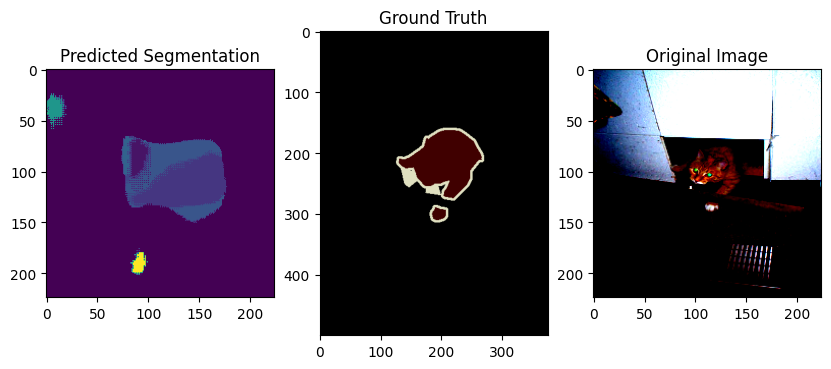

In [45]:
from torchvision.transforms import ToPILImage
from PIL import Image

tensor = model(voc_test_dataset[1000][0].unsqueeze(0).to('cuda')).squeeze(0)
normalized_tensor = ((tensor - tensor.min()) / (tensor.max() - tensor.min())).cpu().detach().numpy()

output = np.argmax(normalized_tensor, axis=0)
target = torch.argmax(train_dataset[2][1], dim=0).numpy()
print(normalized_tensor.shape)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(output)
axes[0].set_title('Predicted Segmentation')

# Display the second image on the second subplot
axes[1].imshow(voc_test_dataset[1000][1])
axes[1].set_title('Ground Truth')

axes[2].imshow(np.transpose(voc_test_dataset[1000][0], (1, 2, 0)))
axes[2].set_title('Original Image')

plt.show()

### Conclusion